<a href="https://colab.research.google.com/github/vittoria-thomasini/Extract_skintone_image/blob/main/Extract_Skin_Tone_from_an_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to extract Skin from and Image and Find the Dominant Colours/Tone

This the online notebook containing the explaination of the code for the article found at https://goo.gl/bpkVn3

If you are interested in testing out with code create a copy of this notebook and go to  menu on top "Runtime -> Run All"


In [37]:
!pip install imutils
!pip install xmltodict
!pip install colormath

  Preparing metadata (setup.py) ... done
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39405 sha256=20ef08a0a0f2598c1f65f23e42692b0151e0acbfdabad987752e69ab1050fa78
  Stored in directory: /root/.cache/pip/wheels/ab/b3/4d/c0738759c25a1df01958068f162cf2a9dc3ab1da8b972cfcfc
Successfully built colormath


## Section One : Importing Libraries

 - **numpy** : OpenCV uses Numpy for numerical operation. Hence Numpy is used to align input with the respective data type

 - **cv2** : OpenCV used for image processing

 - **Counter** : Useful for counting labels

 - **imutils** :  Useful utilities for image processing

 - **pprint** :  Library to pretty print data

 - **matplotlib** :  Normally used as a graph plotting lirbary , but we will use it show inline images since "cv2.imshow" doesn't work on collab

 - **pandas** :
 - **urllib** :

In [20]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt
import pandas as pd
import urllib.request

MST Swatches are 10 single-colored rectangles, and each swatch provides the most representative color within its MST group. The swatches are created for researchers who need to use the exact color values of the MST scale for their studies and for reference when running evaluations.
Color format used is CIE-LAB, but its possible to use HEX, HSL, RGB and CIE-LCH.
Can check information mentioned on https://skintone.google/get-started

In [21]:
#skinMap =
#lab(94.211, 1.503, 5.422)
#lab(92.275, 2.061, 7.28)
#lab(93.091, 0.216, 14.205)
#lab(87.573, 0.459, 17.748)
#lab(77.902, 3.471, 23.136)
#lab(55.142, 7.783, 26.74)
#lab(42.47, 12.325, 20.53)
#lab(30.678, 11.667, 13.335)
#lab(21.069, 2.69, 5.964)
#lab(14.61, 1.482, 3.525)

## Section Two.1 : Function to Extract Skin Color





Read files from github repository and create a local copy in real time to not be mandatory have the files in the machine.
The files for nose and mouth identification are not from the official haarcascad repository but from a second one shared by the community link below.

NOSE and MOUTH xml -> https://github.com/atduskgreg/opencv-processing/tree/master/lib/cascade-files

In [22]:
import requests
import urllib3
def create_file(url, name, extension):
  file_url = url
  http     = urllib3.PoolManager()
  response = http.request('GET', file_url)
  data     = response.data.decode('utf-8')
  file_name = name + '.' + extension

  with open(file_name, 'w') as arquivo:
      arquivo.write(data)

  file_path = '/content/'+ file_name

  return file_path
create_file('https://raw.githubusercontent.com/vittoria-thomasini/Extract_skintone_image/main/haarcascade/haarcascade_mcs_mouth.xml', 'haarcascade_mcs_mouth', 'xml')
create_file('https://raw.githubusercontent.com/vittoria-thomasini/Extract_skintone_image/main/haarcascade/haarcascade_mcs_nose.xml', 'haarcascade_mcs_nose', 'xml')
create_file('https://raw.githubusercontent.com/vittoria-thomasini/Extract_skintone_image/6ea08df8350b27a95f4856c710f5239279559413/mst-e_dataset_details.csv', 'dataset_details', 'csv')

'/content/dataset_details.csv'

The ***extractSkin*** function takes an 8 bit 3 channel image in the BGR colorspace (as mentioned in the article this is how OpenCV reads color images) and returns the extracted image in same colorspace.

The function works by using the** HSV colorspace** and uses thresholding (Thresholding is a process of filtering out pixel based on specified thresdhold parameter) to extracts pixel that corresponds to the skin color range,

In [23]:
def featuresIdentification(image):
  global cropped_image

  #Upload xml
  mouth_xml = r'/content/haarcascade_mcs_mouth.xml'
  nose_xml = r'/content/haarcascade_mcs_nose.xml'

  #read xml
  face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  eye_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
  mouth_detector = cv2.CascadeClassifier(mouth_xml)
  nose_detector = cv2.CascadeClassifier(nose_xml)

  #Convert image from BGR to GRAY
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
  faces = face_detector.detectMultiScale(gray,
                                        scaleFactor=1.05,
                                        minNeighbors=5)

  # For each face
  for (x, y, w, h) in faces:
      # Draw rectangle around the face
      cv2.rectangle(gray, (x, y), (x+w, y+h), (0, 0, 0), 2)
      roi_face = gray[y:y+h, x:x+w]
      cropped_image = image[y:y+h, x:x+w]
      print("aqui crop FACE")
      plt.imshow(cropped_image)
      plt.show()

  if not cropped_image.any():
    print("Não Identificado Rosto")
    cropped_image = gray
  # Detect eye
  eyes = eye_detector.detectMultiScale(cropped_image,
                                       scaleFactor=1.05,
                                       minNeighbors=5)
  for (ex,ey,ew,eh) in eyes:
      cv2.rectangle(cropped_image,(ex,ey),(ex+ew,ey+eh),(0,0,0),-2)
      # cropped_image = img[y:y+h, x:x+w]
      # roi_eye = roi_face[y:y+h, x:x+w]

  # Detect mouth
  mouth = mouth_detector.detectMultiScale(cropped_image,
                                       scaleFactor=1.05,
                                       minNeighbors=5)
  for (xm,ym,wm,hm) in mouth:
      cv2.rectangle(cropped_image,(xm,ym),(xm+wm,ym+hm),(0,0,0),-2)
      # cropped_image = image[y:y+h, x:x+w]
      # roi_mouth = roi_face[y:y+h, x:x+w]
  # print("aqui crop BOCA")
  # plt.imshow(cropped_image)
  # plt.show()

  # Detect nose
  nose = nose_detector.detectMultiScale(cropped_image,
                                       scaleFactor=1.05,
                                       minNeighbors=5)
  for (xn,yn,wn,hn) in nose:
      cv2.rectangle(cropped_image,(xn,yn),(xn+wn,yn+hn),(0,0,0),-2)
      # cropped_image = image[y:y+h, x:x+w]
      # roi_nose = roi_face[y:y+h, x:x+w]
      # print("cropped image in nose")
      # plt.imshow(cropped_image)
      # plt.show()

  # Converting from BGR Colours Space to HSV
  output =  cv2.cvtColor(cropped_image,cv2.COLOR_BGR2HSV)
  plt.imshow(output)
  plt.show()
  return output


In [24]:
def extractSkin(image):
    # Takin image without features
    img = featuresIdentification(image)

    # Defining HSV Threadholds
    lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
    upper_threshold = np.array([20, 255, 255], dtype=np.uint8)

    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

    # Extracting skin from the threshold mask
    skin = cv2.bitwise_and(img, img, mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)

## Section Two.2 :  Function to remove black pixels from extracted image

The ***removeBlack*** function is more sort of the utility function to remove out the black pixel from the skin extracted. Since OpenCV by default doesn't handle transparent images and replaces those with zeros(black in color word).

This function is useful when thresholding is used in the image.

In [25]:
def removeBlack(estimator_labels, estimator_cluster):

  # Check for black
  hasBlack = False

  # Get the total number of occurance for each color
  occurance_counter = Counter(estimator_labels)


  # Quick lambda function to compare to lists
  compare = lambda x, y: Counter(x) == Counter(y)

  # Loop through the most common occuring color
  for x in occurance_counter.most_common(len(estimator_cluster)):

    # Quick List comprehension to convert each of RBG Numbers to int
    color = [int(i) for i in estimator_cluster[x[0]].tolist() ]



    # Check if the color is [0,0,0] that if it is black
    if compare(color , [0,0,0]) == True:
      # delete the occurance
      del occurance_counter[x[0]]
      # remove the cluster
      hasBlack = True
      estimator_cluster = np.delete(estimator_cluster,x[0],0)
      break


  return (occurance_counter,estimator_cluster,hasBlack)



## Section Two.3 : Extract Colour Information

The ***getColorInfomation*** function does all the heavy lifiting to make sense of prediction that came from the clustering.

Taking the prediction labels (***estimator_labels***) and the cluster centroids(***estimator_cluster***) as the input and returns an array of dictionaries of the extracted colours.

The function also takes an optional parameter (***hasThresholding***) to indicate whether a mask was used. This passed from the ***extractDominantColor*** function


In [26]:
def getColorInformation(estimator_labels, estimator_cluster,hasThresholding=False):

  # Variable to keep count of the occurance of each color predicted
  occurance_counter = None

  # Output list variable to return
  colorInformation = []


  #Check for Black
  hasBlack =False

  # If a mask has be applied, remove th black
  if hasThresholding == True:

    (occurance,cluster,black) = removeBlack(estimator_labels,estimator_cluster)
    occurance_counter =  occurance
    estimator_cluster = cluster
    hasBlack = black

  else:
    occurance_counter = Counter(estimator_labels)

  # Get the total sum of all the predicted occurances
  totalOccurance = sum(occurance_counter.values())


  # Loop through all the predicted colors
  for x in occurance_counter.most_common(len(estimator_cluster)):

    index = (int(x[0]))

    # Quick fix for index out of bound when there is no threshold
    index =  (index-1) if ((hasThresholding & hasBlack)& (int(index) !=0)) else index

    # Get the color number into a list
    color = estimator_cluster[index].tolist()

    # Get the percentage of each color
    color_percentage= (x[1]/totalOccurance)

    #make the dictionay of the information
    colorInfo = {"cluster_index":index , "color": color , "color_percentage" : color_percentage }

    # Add the dictionary to the list
    colorInformation.append(colorInfo)


  return colorInformation

## Section Two.4 : Putting it All together

The ***extractDominantColor*** is the function that call the above function to output the information.

The function take an 8 bit 3 channel BGR image as the input , the number of colors to be extracted. This does all the super heavy lifting by sparkling some magic power of machine learning.


As mention in the article , An unsupervised clustering algorithm, ***KMeans Clustering*** is used to cluster the pixel data based on their RGB values.


The function also takes an optional parameter (***hasThresholding***) to indicate whether a thresholding mask was used. This passed to the ***getColorInformation*** function




img.reshape tem o papel de mudar o formato do array sem mudar o conteudo

In [27]:
from sklearn import cluster

def extractDominantColor(image,number_of_colors=10,hasThresholding=False):

  # Quick Fix Increase cluster counter to neglect the black(Read Article)
  if hasThresholding == True:
    number_of_colors +=1

  # Taking Copy of the image
  img = image.copy()

  # Convert Image into RGB Colours Space
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

  # Reshape Image
  img = img.reshape((img.shape[0]*img.shape[1]) , 3)

  #Initiate KMeans Object
  estimator = KMeans(n_clusters=number_of_colors, random_state=0)

  # Fit the image
  estimator.fit(img)

  # Get Colour Information
  colorInformation = getColorInformation(estimator.labels_,estimator.cluster_centers_,hasThresholding)
  return colorInformation
  print(colorInformation)

## Section Two.4.1 : Putting it All together: Making a Visually Representation

The ***plotColorBar*** function gives a visually representation of the extracted color information.

Taking the color information (***colorInformation***) as input  and returns
 ***500x100 8 bit 3 channel BGR colorspace image***

In [28]:
def plotColorBar(colorInformation):
  #Create a 500x100 black image
  color_bar = np.zeros((100,500,3), dtype="uint8")

  top_x = 0
  for x in colorInformation:
    bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

    color = tuple(map(int,(x['color'])))

    cv2.rectangle(color_bar , (int(top_x),0) , (int(bottom_x),color_bar.shape[0]) ,color , -1)
    top_x = bottom_x

  return color_bar

## Section Two.4.2 : Putting it All together: Pretty Print

The function makes print out the color information in a readable manner

In [29]:
def prety_print_data(color_info):
  for x in color_info:
    print(pprint.pformat(x))

Creating CVS file to save results calculated.

In [30]:
#create CSV file
import csv
headerList = ['image_name', 'subject', 'light', 'MST', 'MST_RGB', 'RGB', 'LAB','distancia_rgb','minimo_rgb', 'classificacao_indicada_rgb', 'distancia_lab', 'minimo_lab', 'classificacao_indicada_lab']

with open('dataset_details_answer.csv', 'w', newline='') as file:
    header = csv.DictWriter(file, delimiter=',', fieldnames=headerList)
    header.writeheader()


## Section Three: Baking the Pie
The below lines of code, is the implementation of the above defined function.

In [31]:
def get_rgb_color(color):
  rgb = []
  df = pd.DataFrame.from_dict(color)
  r = df.loc[0, 'color']
  rgb = r
  g = df.loc[1, 'color']
  rgb = g
  b = df.loc[2, 'color']
  rgb = b
  r = float(r)
  g = float(g)
  b = float(b)

  return rgb, r, g, b

In [32]:
import csv
import math
list_distance = []

def get_distances(r, g, b):
  # else : #(mst == 1)
  mst_rgb = "246, 237, 228"
  mst_r = 246
  mst_g = 237
  mst_b = 228
  distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
  list_distance.append(distancia)
  print("1", distancia)
  # elif (mst == 2):
  mst_rgb = "243, 231, 219"
  mst_r = 243
  mst_g = 231
  mst_b = 219
  distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
  list_distance.append(distancia)
  print("2", distancia)
  # elif (mst == 3):
  mst_rgb = "247, 234, 208"
  mst_r = 247
  mst_g = 234
  mst_b = 208
  distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
  list_distance.append(distancia)
  print("3",distancia)
  # elif (mst == 4):
  mst_rgb = "234, 218, 186"
  mst_r = 234
  mst_g = 218
  mst_b = 186
  distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
  list_distance.append(distancia)
  print("4",distancia)
  # elif (mst == 5):
  mst_rgb = "215, 189, 150"
  mst_r = 215
  mst_g = 189
  mst_b = 150
  distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
  list_distance.append(distancia)
  print("5",distancia)
  # elif (mst == 6):
  mst_rgb = "160, 126, 86"
  mst_r = 160
  mst_g = 126
  mst_b = 86
  distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
  list_distance.append(distancia)
  print("6",distancia)
  # elif (mst == 7):
  mst_rgb = "130, 92, 67"
  mst_r = 130
  mst_g = 92
  mst_b = 67
  distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
  list_distance.append(distancia)
  print("7",distancia)
  # elif (mst == 8):
  mst_rgb = "96, 65, 52"
  mst_r = 96
  mst_g = 65
  mst_b = 52
  distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
  list_distance.append(distancia)
  print("8",distancia)
  # elif (mst == 9):
  mst_rgb = "58, 49, 42"
  mst_r = 58
  mst_g = 49
  mst_b = 42
  distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
  list_distance.append(distancia)
  print("9",distancia)
  #  if(mst == 10):
  mst_rgb = "41, 36, 32"
  mst_r = 41
  mst_g = 36
  mst_b = 32
  distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
  list_distance.append(distancia)
  print("10", distancia)
  return list_distance

In [43]:
from skimage import data
import numpy as np
import colour
import skimage.color
list_distance_lab = []

def get_lab_color(lab, mst):
  list_distance_lab.clear()
  #Monk Palette colors in Lab
# else : #(mst == 1)
  mst_lab = np.array([94.211, 1.503, 5.422])
  distance_cie2000 = skimage.color.deltaE_ciede2000(lab, mst_lab)
  list_distance_lab.append(distance_cie2000)
  print("1",distance_cie2000)
# elif (mst == 2):
  mst_lab = np.array([92.275, 2.061, 7.28])
  distance_cie2000 = skimage.color.deltaE_ciede2000(lab, mst_lab)
  list_distance_lab.append(distance_cie2000)
  print("2",distance_cie2000)
# elif (mst == 3):
  mst_lab = np.array([93.091, 0.216, 14.205])
  distance_cie2000 = skimage.color.deltaE_ciede2000(lab, mst_lab)
  list_distance_lab.append(distance_cie2000)
  print("3",distance_cie2000)
# elif (mst == 4):
  mst_lab = np.array([87.573, 0.459, 17.748])
  distance_cie2000 = skimage.color.deltaE_ciede2000(lab, mst_lab)
  list_distance_lab.append(distance_cie2000)
  print("4",distance_cie2000)
# elif (mst == 5):
  mst_lab = np.array([77.902, 3.471, 23.136])
  distance_cie2000 = skimage.color.deltaE_ciede2000(lab, mst_lab)
  list_distance_lab.append(distance_cie2000)
  print("5",distance_cie2000)
# elif (mst == 6):
  mst_lab = np.array([55.142, 7.783, 26.74])
  distance_cie2000 = skimage.color.deltaE_ciede2000(lab, mst_lab)
  list_distance_lab.append(distance_cie2000)
  print("6",distance_cie2000)
# elif (mst == 7):
  mst_lab = np.array([42.47, 12.325, 20.53])
  distance_cie2000 = skimage.color.deltaE_ciede2000(lab, mst_lab)
  list_distance_lab.append(distance_cie2000)
  print("7",distance_cie2000)
# elif (mst == 8):
  mst_lab = np.array([30.678, 11.667, 13.335])
  distance_cie2000 = skimage.color.deltaE_ciede2000(lab, mst_lab)
  list_distance_lab.append(distance_cie2000)
  print("8",distance_cie2000)
# elif (mst == 9):
  mst_lab = np.array([21.069, 2.69, 5.964])
  distance_cie2000 = skimage.color.deltaE_ciede2000(lab, mst_lab)
  list_distance_lab.append(distance_cie2000)
  print("9",distance_cie2000)
 # if(mst == 10):
  mst_lab = np.array([14.61, 1.482, 3.525])
  distance_cie2000 = skimage.color.deltaE_ciede2000(lab, mst_lab)
  list_distance_lab.append(distance_cie2000)
  print("10",distance_cie2000)

  return list_distance_lab

/content/subject00/PXL_20220922_132845778.PORTRAIT.jpg


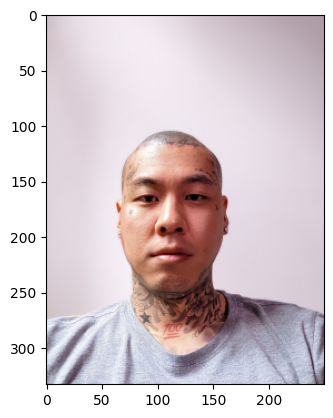

aqui crop FACE


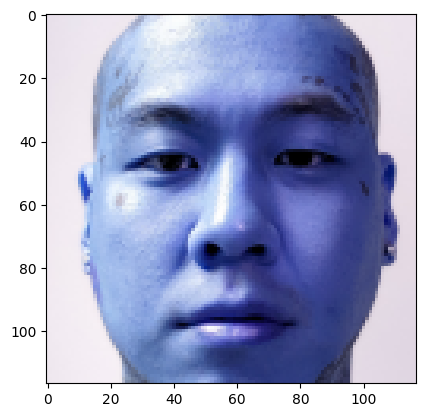

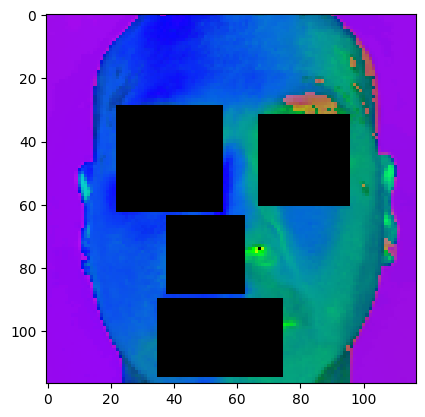

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


{'cluster_index': 4, 'color': [123.30388423457711, 58.83625285605485, 50.43869002284845], 'color_percentage': 0.2071687983578083}
Color Bar


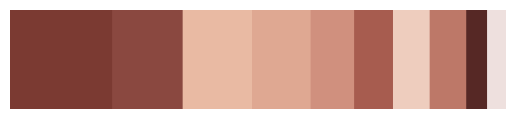

color {'cluster_index': 4, 'color': [123.30388423457711, 58.83625285605485, 50.43869002284845], 'color_percentage': 0.2071687983578083}
lab [ 53 128 128]
mst 3
subject 89    subject_0
light 89  well_lit
1 279.8654612864828
2 269.03611501281233
3 266.0989172670135
4 236.56626389486516
5 187.78507172133035
6 84.39301280305247
7 37.668940509798986
8 28.03447095977439
9 66.57747859203604
10 87.38082795649761
list [279.8654612864828, 269.03611501281233, 266.0989172670135, 236.56626389486516, 187.78507172133035, 84.39301280305247, 37.668940509798986, 28.03447095977439, 66.57747859203604, 87.38082795649761]
minimo 28.03447095977439
indicado: 8
classificao mst 266.0989172670135
1 46.356899772366084
2 45.406789235370965
3 47.62832322604536
4 45.79485617943995
5 40.67347464563006
6 32.383387899971346
7 30.923654432026368
8 36.06463814285482
9 43.44751482860537
10 46.65456724115614
result_lab [46.356899772366084, 45.406789235370965, 47.62832322604536, 45.79485617943995, 40.67347464563006, 32.3833

IndexError: ignored

In [45]:
from cv2 import imread
import dlib
from imutils import paths
import pandas as pd
import csv
import math
from colormath import color_diff_matrix
# Get Image from path
path = ("/content/subject00/")

imagePaths = list(paths.list_images(path))
for imagePath in imagePaths:
    input_image = cv2.imread(imagePath)
    print(imagePath)
    image = imutils.resize(input_image, width=250)

    #Show image
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    plt.show()

    # Apply Skin Mask
    skin = extractSkin(image)

    # Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors
    dominantColors = extractDominantColor(skin,hasThresholding=True)
    print(dominantColors[0])

    #Show in the dominant color information
    # print("Color Information")
    # prety_print_data(dominantColors)

    #Show in the dominant color as bar
    print("Color Bar")
    colour_bar = plotColorBar(dominantColors)
    plt.axis("off")
    plt.imshow(colour_bar)
    plt.show()

    #check CSV created
    dataset = pd.read_csv("/content/dataset_details.csv")
    #return values from csv
    image_name = imagePath.replace(path, '')

    #return first dominant color
    color = dominantColors[0]
    print( 'color',color)

    #return rgb color from dominat color
    rgb, r, g, b = get_rgb_color(color)
    bgr = cv2.cvtColor( np.uint8([[rgb]] ), cv2.COLOR_RGB2BGR)[0][0]
    lab = cv2.cvtColor( np.uint8([[bgr]] ), cv2.COLOR_BGR2LAB)[0][0]
    print('lab', lab)

    #return mst color Monk classification
    img = dataset.loc[dataset['image_ID'] == image_name]
    mst = pd.DataFrame.from_dict(img.MST)
    mst = str(mst)
    mst = mst[13:17]
    mst = int(mst)
    print('mst', mst)

    #return subject information
    subject = pd.DataFrame.from_dict(img.subject_name)
    subject = str(subject)
    subject = subject[18:33]
    print('subject',subject)

    #return light informaton
    light = pd.DataFrame.from_dict(img.lighting)
    light = str(light)
    light = light[15:30]
    print('light',light)

    list_distance = []
    list_distance = get_distances(r, g, b)

    print("list", list_distance)

    minimo = min(list_distance)
    print("minimo",minimo)
    classificacao_indicada = 0
    classificacao_indicada = list_distance.index(minimo)
    #adjust classification to correspond mast list
    classificacao_indicada = classificacao_indicada + 1
    print('indicado:', classificacao_indicada)

    classificacao_mst = 0
    classificacao_mst = list_distance[mst-1]
    print('classificao mst', classificacao_mst)

    list_lab = []
    list_lab = get_lab_color(lab, mst)
    print('result_lab', list_lab)
    minimo_lab = min(list_lab)
    print("minimo",minimo_lab)
    classificacao_indicada_lab = 0
    classificacao_indicada_lab = list_lab.index(minimo_lab)
    #adjust classification to correspond mast list
    classificacao_indicada_lab = classificacao_indicada_lab + 1
    print('indicado:', classificacao_indicada_lab)

    # print(result_lab, "lab")
    if (dataset.image_ID == image_name).any() == True:
    #Monk Palette colors in RGB
      print(mst)
      if(mst == 10):
        mst_rgb = "41, 36, 32"
        mst_r = 41
        mst_g = 36
        mst_b = 32
        mst_lab = np.array([14.61, 1.482, 3.525])
      elif (mst == 9):
        mst_rgb = "58, 49, 42"
        mst_r = 58
        mst_g = 49
        mst_b = 42
        mst_lab = np.array([21.069, 2.69, 5.964])
      elif (mst == 8):
        mst_rgb = "96, 65, 52"
        mst_r = 96
        mst_g = 65
        mst_b = 52
        mst_lab = np.array([30.678, 11.667, 13.335])
      elif (mst == 7):
        mst_rgb = "130, 92, 67"
        mst_r = 130
        mst_g = 92
        mst_b = 67
        mst_lab = np.array([42.47, 12.325, 20.53])
      elif (mst == 6):
        mst_rgb = "160, 126, 86"
        mst_r = 160
        mst_g = 126
        mst_b = 86
        mst_lab = np.array([55.142, 7.783, 26.74])
      elif (mst == 5):
        mst_rgb = "215, 189, 150"
        mst_r = 215
        mst_g = 189
        mst_b = 150
        mst_lab = np.array([77.902, 3.471, 23.136])
      elif (mst == 4):
        mst_rgb = "234, 218, 186"
        mst_r = 234
        mst_g = 218
        mst_b = 186
        mst_lab = np.array([87.573, 0.459, 17.748])
      elif (mst == 3):
        mst_rgb = "247, 234, 208"
        mst_r = 247
        mst_g = 234
        mst_b = 208
        mst_lab = np.array([93.091, 0.216, 14.205])
      elif (mst == 2):
        mst_rgb = "243, 231, 219"
        mst_r = 243
        mst_g = 231
        mst_b = 219
        mst_lab = np.array([92.275, 2.061, 7.28])
      else : #(mst == 1)
        mst_rgb = "246, 237, 228"
        mst_r = 246
        mst_g = 237
        mst_b = 228
        mst_lab = np.array([94.211, 1.503, 5.422])
    distance_rgb = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
    distance_lab = skimage.color.deltaE_ciede2000(lab, mst_lab)
    print('distance rgb',distance_rgb)
    print('distance lab',distance_lab)

    with open('dataset_details_answer.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([image_name, subject, light, mst, mst_rgb, rgb, lab, distance_rgb, minimo, classificacao_indicada, distance_lab, minimo_lab, classificacao_indicada_lab])


In [35]:
# from cv2 import imread
# import dlib
# from imutils import paths
# import pandas as pd
# import csv
# import math

#   # Get Image from URL. If you want to upload an image file and use that comment the below code and replace with  image=cv2.imread("FILE_NAME")
#   #
# # input_image =  imutils.url_to_image("https://raw.githubusercontent.com/vittoria-thomasini/Extract_skintone_image/main/terry.jpg")
# # # image =  imutils.url_to_image("https://raw.githubusercontent.com/vittoria-thomasini/Extract_skintone_image/main/jolie.jpg")
# # input_image =  imutils.url_to_image("https://raw.githubusercontent.com/vittoria-thomasini/Extract_skintone_image/main/terry.jpg")
# # input_image = imread("/content/PXL_20220922_174011830.jpg")
# # path = ("/content/subject01")

# # imagePaths = list(paths.list_images(path))
# # for imagePath in imagePaths:
# #     input_image = cv2.imread(imagePath)
# #     print(imagePath)
# image = imutils.resize(input_image, width=250)

# #Show image
# plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
# plt.show()

# # Apply Skin Mask
# skin = extractSkin(image)

# # Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors
# dominantColors = extractDominantColor(skin,hasThresholding=True)
# print(dominantColors[0])

# #Show in the dominant color information
# # print("Color Information")
# # prety_print_data(dominantColors)

# #Show in the dominant color as bar
# print("Color Bar")
# colour_bar = plotColorBar(dominantColors)
# plt.axis("off")
# plt.imshow(colour_bar)
# plt.show()



# #check CSV created
# dataset = pd.read_csv("/content/dataset_details.csv")
# #return values from csv
# image_name = 'PXL_20220922_174011830.jpg'

# img = dataset.loc[dataset['image_ID'] == image_name]

# color = dominantColors[0]
# df = pd.DataFrame.from_dict(color)
# r = df.loc[0, 'color']
# r = str(r)
# print(r)
# b = df.loc[1, 'color']
# b = str(b)
# print(b)
# g = df.loc[2, 'color']
# g = str(g)
# print(g)
# rgb =  r + ',' + g + ',' + b
# # print(rgb)
# mst = pd.DataFrame.from_dict(img.MST)
# mst = str(mst)
# mst = mst[15:17]
# print(mst)

# subject = pd.DataFrame.from_dict(img.subject_name)
# subject = str(subject)
# subject = subject[23:33]
# print(subject)
# r = float(r)
# g = float(g)
# b = float(b)


# #  if(mst == 10):
# mst_rgb = "41, 36, 32"
# mst_r = 41
# mst_g = 36
# mst_b = 32
# distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
# print(distancia)
# # elif (mst == 9):
# mst_rgb = "58, 49, 42"
# mst_r = 58
# mst_g = 49
# mst_b = 42
# distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
# print(distancia)
# # elif (mst == 8):
# mst_rgb = "96, 65, 52"
# mst_r = 96
# mst_g = 65
# mst_b = 52
# distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
# print(distancia)
# # elif (mst == 7):
# mst_rgb = "130, 92, 67"
# mst_r = 130
# mst_g = 92
# mst_b = 67
# distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
# print(distancia)
# # elif (mst == 6):
# mst_rgb = "160, 126, 86"
# mst_r = 160
# mst_g = 126
# mst_b = 86
# distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
# print(distancia)
# # elif (mst == 5):
# mst_rgb = "215, 189, 150"
# mst_r = 215
# mst_g = 189
# mst_b = 150
# distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
# print(distancia)
# # elif (mst == 4):
# mst_rgb = "234, 218, 186"
# mst_r = 234
# mst_g = 218
# mst_b = 186
# distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
# print(distancia)
# # elif (mst == 3):
# mst_rgb = "247, 234, 208"
# mst_r = 247
# mst_g = 234
# mst_b = 208
# distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
# print(distancia)
# # elif (mst == 2):
# mst_rgb = "243, 231, 219"
# mst_r = 243
# mst_g = 231
# mst_b = 219
# distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
# print(distancia)
# # else : #(mst == 1)
# mst_rgb = "246, 237, 228"
# mst_r = 246
# mst_g = 237
# mst_b = 228
# distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
# print(distancia)

# if (dataset.image_ID == image_name).any() == True:
# #Monk Palette colors in RGB
#   if(mst == 10):
#     mst_rgb = "41, 36, 32"
#     mst_r = 41
#     mst_g = 36
#     mst_b = 32
#   elif (mst == 9):
#     mst_rgb = "58, 49, 42"
#     mst_r = 58
#     mst_g = 49
#     mst_b = 42
#   elif (mst == 8):
#     mst_rgb = "96, 65, 52"
#     mst_r = 96
#     mst_g = 65
#     mst_b = 52
#   elif (mst == 7):
#     mst_rgb = "130, 92, 67"
#     mst_r = 130
#     mst_g = 92
#     mst_b = 67
#   elif (mst == 6):
#     mst_rgb = "160, 126, 86"
#     mst_r = 160
#     mst_g = 126
#     mst_b = 86
#   elif (mst == 5):
#     mst_rgb = "215, 189, 150"
#     mst_r = 215
#     mst_g = 189
#     mst_b = 150
#   elif (mst == 4):
#     mst_rgb = "234, 218, 186"
#     mst_r = 234
#     mst_g = 218
#     mst_b = 186
#   elif (mst == 3):
#     mst_rgb = "247, 234, 208"
#     mst_r = 247
#     mst_g = 234
#     mst_b = 208
#   elif (mst == 2):
#     mst_rgb = "243, 231, 219"
#     mst_r = 243
#     mst_g = 231
#     mst_b = 219
#   else : #(mst == 1)
#     mst_rgb = "246, 237, 228"
#     mst_r = 246
#     mst_g = 237
#     mst_b = 228

# distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
# print("distancia", distancia)

# with open('dataset_details_answer.csv', 'a', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow([image_name, subject, mst, mst_rgb, mst_r, mst_g, mst_b, rgb,  r, g, b])


In [59]:
from skimage.color.delta_e import deltaE_ciede2000
# -*- coding: utf-8 -*-
"""
The functions in this module are used for comparing two LabColor objects
using various Delta E formulas.
"""

import numpy

from colormath import color_diff_matrix

color1 = np.array([93.091, 0.216, 14.205])
def _get_lab_color1_vector(color1):
    """
    Converts an LabColor into a NumPy vector.

    :param LabColor color:
    :rtype: numpy.ndarray
    """
    if not color.__class__.__name__ == 'LabColor':
        raise ValueError(
            "Delta E functions can only be used with two LabColor objects.")
    return numpy.array([color.lab_l, color.lab_a, color.lab_b])

color2 = np.array([ 53, 128, 128])
def _get_lab_color2_matrix(COLOR_BGR2LAB):
    """
    Converts an LabColor into a NumPy matrix.

    :param LabColor color:
    :rtype: numpy.ndarray
    """
    if not color.__class__.__name__ == 'LabColor':
        raise ValueError(
            "Delta E functions can only be used with two LabColor objects.")
    return numpy.array([(color.lab_l, color.lab_a, color.lab_b)])


# noinspection PyPep8Naming
def delta_e_cie1976(color1, color2):
    """
    Calculates the Delta E (CIE1976) of two colors.
    """
    color1_vector = _get_lab_color1_vector(color1)
    color2_matrix = _get_lab_color2_matrix(color2)
    delta_e = color_diff_matrix.delta_e_cie1976(color1_vector, color2_matrix)[0]
    return numpy.asscalar(delta_e)



# noinspection PyPep8Naming
def delta_e_cie1994(color1, color2, K_L=1, K_C=1, K_H=1, K_1=0.045, K_2=0.015):
    """
    Calculates the Delta E (CIE1994) of two colors.

    K_l:
      0.045 graphic arts
      0.048 textiles
    K_2:
      0.015 graphic arts
      0.014 textiles
    K_L:
      1 default
      2 textiles
    """
    color1_vector = _get_lab_color1_vector(color1)
    color2_matrix = _get_lab_color2_matrix(color2)
    delta_e = color_diff_matrix.delta_e_cie1994(
        color1_vector, color2_matrix, K_L=K_L, K_C=K_C, K_H=K_H, K_1=K_1, K_2=K_2)[0]
    return numpy.asscalar(delta_e)



# noinspection PyPep8Naming
def delta_e_cie2000(color1, color2, Kl=1, Kc=1, Kh=1):
    """
    Calculates the Delta E (CIE2000) of two colors.
    """
    color1_vector = _get_lab_color1_vector(color1)
    color2_matrix = _get_lab_color2_matrix(color2)
    delta_e = color_diff_matrix.delta_e_cie2000(
        color1_vector, color2_matrix, Kl=Kl, Kc=Kc, Kh=Kh)[0]
    return numpy.asscalar(delta_e)



# noinspection PyPep8Naming
def delta_e_cmc(color1, color2, pl=2, pc=1):
    """
    Calculates the Delta E (CMC) of two colors.

    CMC values
      Acceptability: pl=2, pc=1
      Perceptability: pl=1, pc=1
    """
    color1_vector = _get_lab_color1_vector(color1)
    color2_matrix = _get_lab_color2_matrix(color2)
    delta_e = color_diff_matrix.delta_e_cmc(
        color1_vector, color2_matrix, pl=pl, pc=pc)[0]
    return numpy.asscalar(delta_e)

# cie1976 = delta_e_cie1976(color1, color2)
# print(cie1976)
# cie1994 = delta_e_cie1994(color1, color2, 1,1,1)
# print(cie1994)
cie2000 = deltaE_ciede2000(color1, color2, 1,1,1)
print(cie2000)
# cmc = delta_e_cmc(color1, color2, 1,1,1)
# print(cmc)
distance_lab1 = skimage.color.deltaE_ciede2000(color1, color2)
print(distance_lab1)
distance_lab2 = skimage.color.deltaE_ciede2000(color2, color1)
print(distance_lab2)

47.62832322604536
47.62832322604536
47.62832322604536
